# DeerLab Workshop 2023
## EFEPR Summer School
## Hugo Karas

Based on the work by Luis Fábregas Ibáñez & Stefan Stoll

<img style=" alignment:center" src="../images/logo_school23.gif">

## What is DeerLab?

DeerLab is an advanced python based software for analysing DEER/PELDOR data using Tikihnov regularisation

## Getting Started

First we will look at processing a simple 4-pulse DEER trace

In [1]:
import deerlab as dl
# We all need some other packages too
import numpy as np # Numerical calculations and array handling
import matplotlib.pyplot as plt # Plotting

/Users/hugo/.pyenv/versions/3.11.0/envs/deerlab_dev_311/lib/python3.11/site-packages/tqdm-4.65.0-py3.11.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


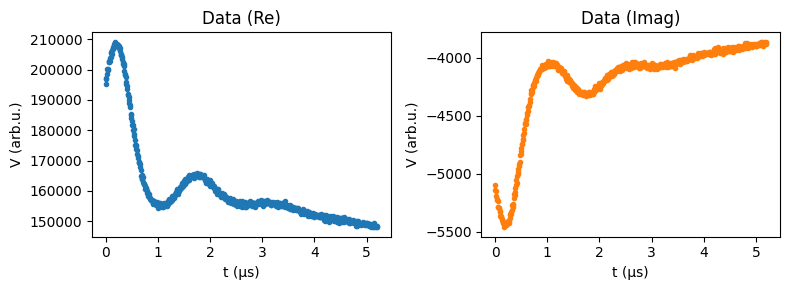

In [28]:
t,V = dl.deerload('../data/example_4pdeer_4.DTA')

# Plot the data
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t,V.real,'.',label='data (real)')
plt.title('Data (Re)')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.subplot(1,2,2)
plt.plot(t,V.imag,'.',label='data (imag)',color='C1')
plt.title('Data (Imag)')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.tight_layout()
plt.show()

## Pre-processing Data

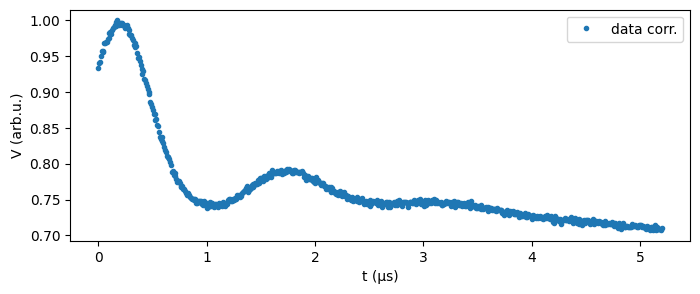

In [3]:
# Phase correction
Vexp = dl.correctphase(V)
# Normalize the data (only for plotting purposes)
Vexp = Vexp/np.max(Vexp)
plt.figure(figsize=(8,3))
plt.plot(t,Vexp,'.',label='data corr.')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.legend()
plt.show()

### Acounting for the start time

Since DeerLab has been designed for multi-pathway data, the definition of the zero point in time is critically important

<img style="width:500px; alignment:center" src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/main/images/4pdeer_sequence_starttime.svg">

In Deerlab the *zerotime* is defined as the time of $\pi$ pulse before the moving pump pulse


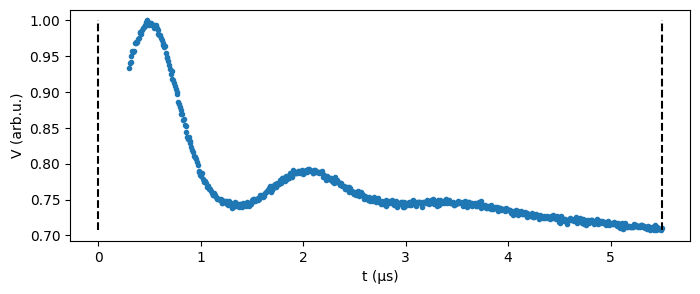

In [4]:
tau1 = 0.5 # µs
tau2 = 5.0 # µs
deadtime = 0.3 # µs

t = t -t[0]
t = t + deadtime

plt.figure(figsize=(8,3))
plt.plot(t,Vexp,'.',label='data corr.')

plt.vlines(0,min(Vexp),max(Vexp),'k',linestyle='dashed')
plt.vlines(tau1+tau2,min(Vexp),max(Vexp),'k',linestyle='dashed')

plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.show()

## Fitting

Before we can fit out data we must first build a model.

We can build a simple dipolar model

In [5]:
# Define the distance range
r = np.linspace(2,5,50) # range from 2.2-5.2nm with

# Construct the dipolar model
Vmodel = dl.dipolarmodel(t,r) 

# Display information about the dipolar model
print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Start   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======= ======== ======== ====== ====================================== 
 mod           0    0.01       1   nonlin     No            Modulation depth                      
 reftime     -20       0      20   nonlin     No      μs    Refocusing time                       
 conc       0.01      50   5e+03   nonlin     No      μM    Spin concentration                    
 P             0       0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======= ======== ======== ====== ====================================== 


DeerLab includes a wide range of built in models which can then handle the different pathways.

- 4pDEER
- fwd5pDEER
- rev5pDEER
- RIDME

and many more...

In [6]:
# Construct model of our 4-pulse DEER experiment
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

# Construct the dipolar signal model including experimental information
Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 

# Display information about the model
print(Vmodel)

Description: 4-pulse DEER dipolar signal model
Signature: (lam1, reftime1, lam2, reftime2, lam3, reftime3, conc, P)
Constants: []
Parameter Table: 
========== ======== ======= ======= ======== ======== ====== ====================================== 
 Name       Lower    Start   Upper    Type    Frozen   Unit   Description                           
========== ======== ======= ======= ======== ======== ====== ====================================== 
 lam1           0     0.01       1   nonlin     No            Amplitude of pathway #1               
 reftime1   0.452      0.5   0.548   nonlin     No      μs    Refocusing time of pathway #1         
 lam2           0     0.01       1   nonlin     No            Amplitude of pathway #2               
 reftime2    5.45      5.5    5.55   nonlin     No      μs    Refocusing time of pathway #2         
 lam3           0     0.01       1   nonlin     No            Amplitude of pathway #3               
 reftime3   -0.048       0   0.048   nonlin 

We can now use this model to fit our data in one go

In [7]:
results = dl.fit(Vmodel,Vexp,verbose=2,  ftol=1e-3,)

[8-8-2023 12:47:27] Preparing the SNLLS analysis...
[8-8-2023 12:47:27] Preparations completed.
[8-8-2023 12:47:27] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4318e+00                                    1.06e+01    
       1              3         7.0283e-01      7.29e-01       2.24e+02       9.15e+00    
       2              4         8.1719e-02      6.21e-01       3.46e+01       2.09e-01    
       3              5         4.1360e-02      4.04e-02       4.66e+01       3.37e-01    
       4              6         1.0571e-02      3.08e-02       4.42e+01       1.95e-01    
       5              7         2.5077e-03      8.06e-03       3.21e+01       3.11e-01    
       6              8         1.8212e-03      6.86e-04       2.45e+00       1.81e-02    
       7              9         1.7035e-03      1.18e-04       4.34e+00       3.72e-02    
       8         

In [8]:
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.979             0.033          0.002  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.011            
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        0.199      (0.167,0.231)                    Amplitude of pathway #1               
 reftime1    0.498      (0.455,0.541)              μs    Refocusing time of pathway #1         
 lam2        0.005      (0.003,0.008)                    A

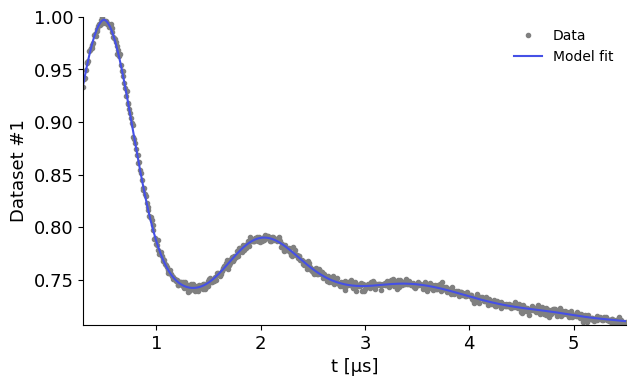

In [9]:
results.plot(axis=t,xlabel='t [μs]')

# Show the plot
plt.show() 

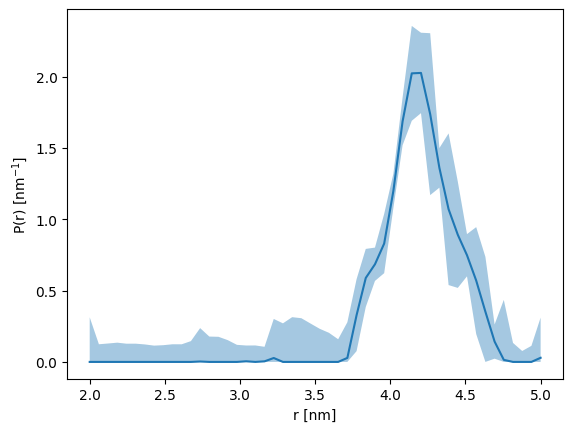

In [10]:
# Get the fitted distance distribution
Pfit = results.P
# Get the uncertainty quantification of the distance distribution
Puq = results.PUncert
# Get its 95% confidence intervals
Pci95 = Puq.ci(95)

# Get the lower/upper boundaries of the confidence intervals
Pci95_lower = Pci95[:,0]
Pci95_upper = Pci95[:,1]

# Plot the fitted distance distribution
plt.plot(r,Pfit)
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95_lower,Pci95_upper,alpha=0.4)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()

In [11]:
mod_fit = results.lam1 + results.lam2 + results.lam3
mod_ci95 = results.lam1Uncert.ci(95) + results.lam2Uncert.ci(95) + results.lam3Uncert.ci(95)

# Spin concentration
conc_fit = results.conc
conc_ci95 = results.concUncert.ci(95)


print(f'Modulation depth: {mod_fit:.3f} ({mod_ci95[0]:.3f},{mod_ci95[1]:.3f})')
print(f'Spin concentration: {conc_fit:.4g}uM ({conc_ci95[0]:.4g},{conc_ci95[1]:.4g})')

Modulation depth: 0.204 (0.169,0.260)
Spin concentration: 124.3uM (96,152.6)


In [12]:
stats = dl.diststats(r,Pfit,Puq,verbose=True)

-------------------------------------------------
Distribution Statistics
-------------------------------------------------
Range                    2.00-5.00 nm
Integral                 1.00
-------------------------------------------------
Location
-------------------------------------------------
Range                    2.00-5.00 nm
Mean                     4.20 (4.19,4.22) nm
Median                   4.20 (4.19,4.20) nm
Interquartile mean       4.20 (4.19,4.21) nm
Mode                     4.20 nm
-------------------------------------------------
Spread
-------------------------------------------------
Standard deviation       0.21 (0.12,0.31) nm
Mean absolute deviation  0.17 (0.16,0.18) nm
Interquartile range      0.28 (0.28,0.29) nm
Variance                 0.05 (0.01,0.09) nm²
-------------------------------------------------
Shape
-------------------------------------------------
Modality                 1
Skewness                 -0.13 (-9.40,9.15) 
Kurtosis                 -0

## Dipolar Pathway Theory

<img src="../images/4pdeer_example.svg" alt="drawing" style="width:600px; margin:auto; display:block; "/>


In reality it is rare that every pulse is perfect, and spins do not flip perfectly. This can result in a dipolar pathway that refocuses at a different time. DeerLab is able to fit a multi-pathway model.

The "2+1" artifact is show as pathway 2. If you get pathway you nearly always have pathway 3 so you **must** use a multi-pathway model not just cut the data.

### Now lets give this a go with some real data

Compared to our previous method we only have to change 1 line:
```python
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

```


Our model will now look a little different:
```
Description: 4-pulse DEER dipolar signal model
Signature: (lam1, reftime1, lam2, reftime2, lam3, reftime3, conc, P)
Constants: []
Parameter Table: 
========== ======== ======= ======= ======== ======== ====== ====================================== 
 Name       Lower    Start   Upper    Type    Frozen   Unit   Description                           
========== ======== ======= ======= ======== ======== ====== ====================================== 
 lam1           0     0.01       1   nonlin     No            Amplitude of pathway #1               
 reftime1   0.452      0.5   0.548   nonlin     No      μs    Refocusing time of pathway #1         
 lam2           0     0.01       1   nonlin     No            Amplitude of pathway #2               
 reftime2    5.45      5.5    5.55   nonlin     No      μs    Refocusing time of pathway #2         
 lam3           0     0.01       1   nonlin     No            Amplitude of pathway #3               
 reftime3   -0.048       0   0.048   nonlin     No      μs    Refocusing time of pathway #3         
 conc        0.01       50   5e+03   nonlin     No      μM    Spin concentration                    
 P              0        0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========== ======== ======= ======= ======== ======== ====== ====================================== 
```
We no longer have a `mod` parameter. Instead we have three `lamx`. These together form your *modulation depth*.

### Your turn now

The file is located at `"../data/deer_multi.DTA"`
```python
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

```


|**Parameter**|**Value**|**Unit**|
|:-----------:|:-------:|:------:|
|tau1|0.4|us|
|tau2|4.2|us|
|deadtime|0.28|us|


#### Solution

In [13]:
t,V = dl.deerload('../data/example_4pdeer_4.DTA')
Vexp = dl.correctphase(V) # Phase correction
Vexp = Vexp/np.max(Vexp)  # Normalize the data (only for plotting purposes)
tau1 = 0.5 # µs
tau2 = 5.0 # µs
deadtime = 0.3 # µs

t = t -t[0]
t = t + deadtime

r = np.linspace(2,5,100) # range from 2.2-5.2nm with 0.02nm resolution

Vmodel = dl.dipolarmodel(t,r) # Construct the dipolar model


my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) # Construct the dipolar signal model including experimental information

results = dl.fit(Vmodel,Vexp, ftol=1e-3)
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.992             0.029          0.002  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.025            
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        0.199      (0.165,0.233)                    Amplitude of pathway #1               
 reftime1    0.498      (0.453,0.543)              μs    Refocusing time of pathway #1         
 lam2        0.005      (0.003,0.008)                    A

In [14]:
Vfit = results.model
Vci95 = results.propagate(Vmodel).ci(95)

Pfit = results.P # Get the fitted distance distribution
Puq = results.PUncert # Get the uncertainty quantification of the distance distribution

Pci95 = Puq.ci(95) # Get its 95% confidence intervals


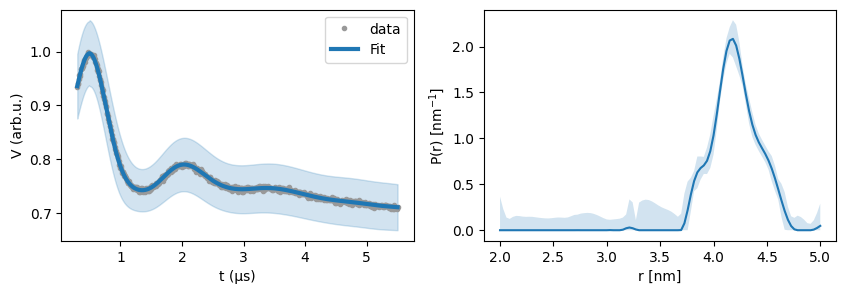

In [15]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.plot(t,Vexp,'.',label='data',color='0.6')
plt.plot(t,Vfit,linewidth=3,color='C0',label='Fit')
plt.fill_between(t,Vci95[:,0],Vci95[:,1],alpha=0.2,color='C0')

plt.legend()
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')


plt.subplot(1,2,2)

# Plot the fitted distance distribution
plt.plot(r,Pfit)
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.2)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()

## Getting Help

Detailed documentation can be found at: jeschkelab.github.io/DeerLab

Including Examples:


### Asking Others
Post questions and queries on the discuisson board: 
<img src="../images/Discussion_Board.png">

### Reporting Issues:
Help the development team buy requesting new features and reporting bugs on

GitHub. We can't fix an issue or implement a new feature if we don't know it exists.
<img src="../images/Issues_Board.png">

## Advanced Techniques

- Custom Dipolar Modelling
- Compactness Criterion
- Global Fitting

## Custom Dipolar Modeling

So far we have looked at fitting using a non-paramateric model free approach. DeerLab is also capable at model based fitting. 

Some possible models are:
- Gaussian (one, two, three)
- Rice (one, two, three)
- Wormchain (for rigid rulers)
- 3D models

In [16]:
Pmodel = dl.dd_gauss
Vmodel = dl.dipolarmodel(t,r,Pmodel, experiment=dl.ex_4pdeer(tau1,tau2, pathways=[1]))
results = dl.fit(Vmodel,Vexp,reg=False)
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.982             0.048          0.002  
========= ============= ============= ===================== ======= 
Model parameters: 
=========== ========= ========================= ====== ============================== 
 Parameter   Value     95%-Confidence interval   Unit   Description                   
=========== ========= ========================= ====== ============================== 
 mod         0.200     (0.200,0.201)                    Modulation depth              
 reftime     0.499     (0.497,0.501)              μs    Refocusing time               
 conc        119.117   (118.004,120.229)          μM    Spin concentration            
 mean        4.200     (4.196,4.205)              nm    Mean                          
 std     

In [17]:
# Extract fitted dipolar signal
Vfit = results.model

# Extract fitted distance distribution
Pfit = results.evaluate(Pmodel,r)
scale = np.trapz(Pfit,r)
Puncert = results.propagate(Pmodel,r,lb=np.zeros_like(r))
Pfit = Pfit/scale
Pci95 = Puncert.ci(95)/scale
Pci50 = Puncert.ci(50)/scale

In [18]:
# Extract the unmodulated contribution
Bfcn = lambda mod,conc,reftime: scale*(1-mod)*dl.bg_hom3d(t-reftime,conc,mod)
Bfit = results.evaluate(Bfcn)
Bci = results.propagate(Bfcn).ci(95)

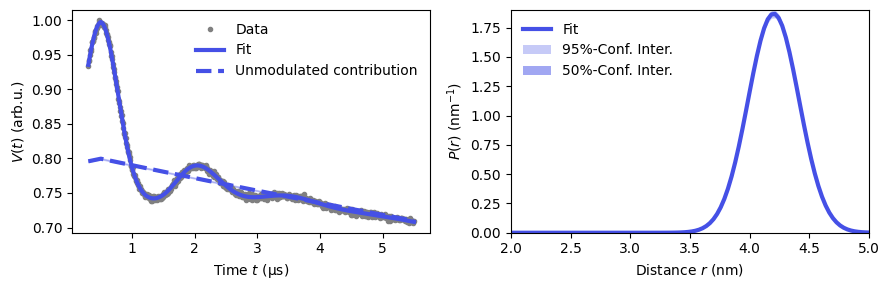

In [19]:
plt.figure(figsize=[9,3])
violet = '#4550e6'
plt.subplot(1,2,1)
# Plot experimental and fitted data
plt.plot(t,Vexp,'.',color='grey',label='Data')
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
plt.plot(t,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(1,2,2)
plt.plot(r,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## Compactness Criterion


It is often the case that there is a non-unique solution for the speration of the background. This is especially tue for noisy data and dataset where the trace is not long enough.

<img src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/2746d801bdf97b7afd75d4f666d8fd414af490d8/images/example_identiability.svg" style="width:700px">

DeerLab has a compactness penalty introduced in the regularization. This has the effect of adding an aditional penalty to the objective function than penalizes non-compact data. 

For nearly all applications it is recomended that the compactness criterion is used.

In [20]:
Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 
compactness = dl.dipolarpenalty(Pmodel=None, r=r, type='compactness')
results = dl.fit(Vmodel,Vexp,penalties=compactness)
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.993             0.030          0.002  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
========================== =================== 
 Regularization parameter   Penalty weight #1  
========================== =================== 
          0.026                   0.046        
========================== =================== 
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        0.199      (0.197,0.201)                    Amplitude

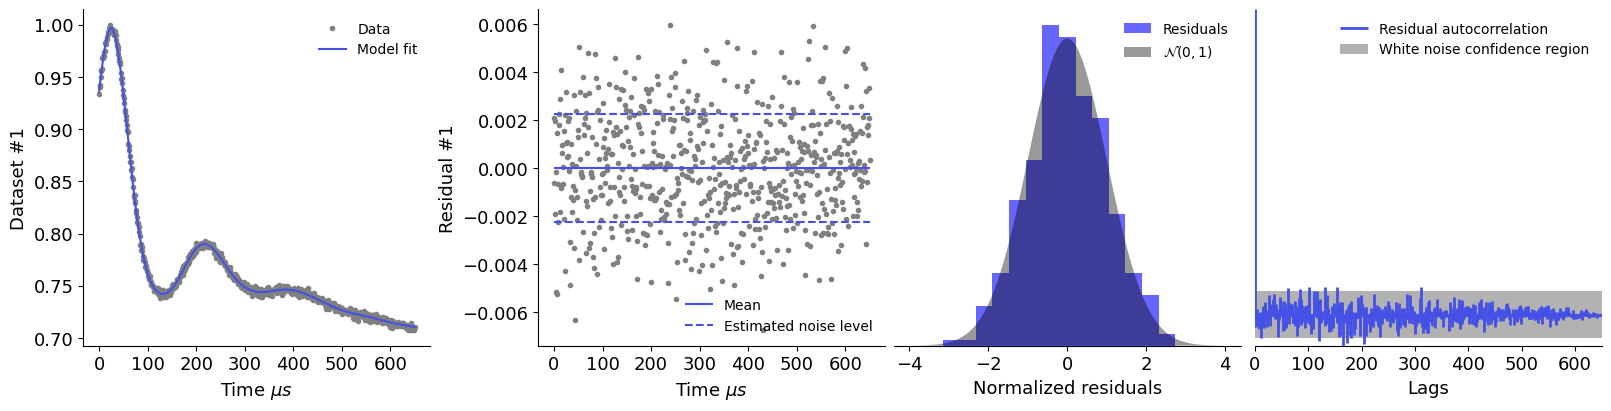

In [21]:
results.plot(gof=True, xlabel='Time $\mu s$');

## Global Fitting

Often you end up with multiple measurments of the same sample. Instead of fitting these traces independently we will fit them all as one, globally.

Here we will use a non parametric fit and the defauly homogenous background model

In this example I am going to ask you to attempt it mostly by yourselves first

In [22]:
# File location
path = '../data/'
file4p = 'example_4pdeer_2.DTA'
file5p = 'example_5pdeer_2.DTA'

# Experimental parameters (4pDEER)
tau1_4p = 0.5               # First int er-pulse delay, μs
tau2_4p = 3.5               # Second inter-pulse delay, μs
deadtime_4p = 0.1           # Acquisition deadtime, μs

# Experimental parameters (reversed 5pDEER)
tau1_5p = 2.9               # First inter-pulse delay, μs
tau2_5p = 3.3               # Second inter-pulse delay, μs
tau3_5p = 0.3               # Third inter-pulse delay, μs
deadtime_5p = 0.1           # Acquisition deadtime, μs

In [23]:
# Load the experimental data (4pDEER)
t4p,V4p = dl.deerload(path + file4p)
V4p = dl.correctphase(V4p)    # Phase correction
V4p = V4p/np.max(V4p)         # Rescaling (aesthetic)
t4p = t4p + deadtime_4p       # Account for deadtime
# Load the experimental data (reversed 5pDEER)
t5p,V5p = dl.deerload(path + file5p)
V5p = dl.correctphase(V5p)    # Phase correction
V5p = V5p/np.max(V5p)         # Rescaling (aesthetic)
t5p = t5p + deadtime_5p       # Account for deadtime

In [24]:
# Load the experimental data (4pDEER)
t4p,V4p = dl.deerload(path + file4p)
V4p = dl.correctphase(V4p)    # Phase correction
V4p = V4p/np.max(V4p)         # Rescaling (aesthetic)
t4p = t4p + deadtime_4p       # Account for deadtime
# Load the experimental data (reversed 5pDEER)
t5p,V5p = dl.deerload(path + file5p)
V5p = dl.correctphase(V5p)    # Phase correction
V5p = V5p/np.max(V5p)         # Rescaling (aesthetic)
t5p = t5p + deadtime_5p       # Account for deadtime

In [25]:
# Run fit
r = np.arange(2.5,6,0.05)

# Construct the individual dipolar signal models
V4pmodel = dl.dipolarmodel(t4p,r,experiment=dl.ex_4pdeer(tau1=tau1_4p,tau2=tau2_4p,pathways=[1,2,3]))
V5pmodel = dl.dipolarmodel(t5p,r,experiment=dl.ex_rev5pdeer(tau1=tau1_5p,tau2=tau2_5p,tau3=tau3_5p,pathways=[1,2]))

# Make the joint model with the distribution as a global parameters
globalmodel = dl.merge(V4pmodel,V5pmodel,addweights=True)
globalmodel = dl.link(globalmodel, P = ['P_1','P_2'])

In [26]:
# Fit the model to the data (with fixed regularization parameter)
results = dl.fit(globalmodel,[V4p,V5p], weights=[1,1])

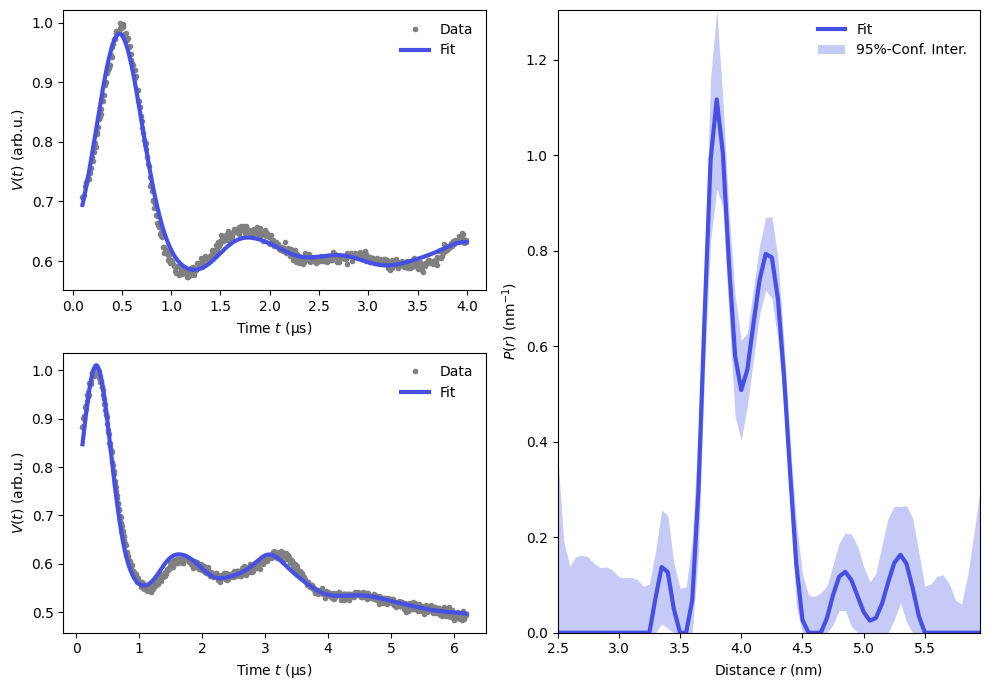

In [27]:
plt.figure(figsize=[10,7])
violet = '#4550e6'

# Extract fitted distance distribution
Pfit = results.P
Pci95 = results.PUncert.ci(95)
Pci50 = results.PUncert.ci(50)
for n,(t,V) in enumerate(zip([t4p,t5p],[V4p,V5p])):

    # Extract fitted dipolar signal
    Vfit = results.model[n]

    plt.subplot(2,2,1+n*2)
    # Plot experimental data
    plt.plot(t,V,'.',color='grey',label='Data')
    # Plot the fitted signal
    plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
    plt.legend(frameon=False,loc='best')
    plt.xlabel('Time $t$ (μs)')
    plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(1,2,2)
plt.plot(r,Pfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()


## Learning More

Luis' Thesis is a really good book that covers all the maths and how to analyse DEER data:


|    **Name**    | **Intials** | **Date last updated** | **Data (GB)** |
| ![](https://jeschkelab.github.io/DeerLab/_static/publications_thesis.png) |     JASO    |                       |      120      |
|                |             |                       |               |
|                |             |                       |               |
